# SimLynx.jl Event-Based Discrete-Event Simulation Example
This is a simple event-based discrete-ev
ent simulation of an N teller, single queue bank using the SimLynx.jl hybrid simulation engine and language in Julia.

In [1]:
using SimLynx
SimLynx.greet()

                   _____ _           _                        _ _
  `\.      ,/'    /  ___(_)         | |                      (_) |
   |\\____//|     \ `--. _ _ __ ___ | |    _   _ _ __ __  __  _| |
   )/_ `' _\(      `--. \ | '_ ` _ \| |   | | | | '_ \\ \/ / | | |
  ,'/-`__'-\`\    /\__/ / | | | | | | |___| |_| | | | |>  < _| | |
  /. (_><_) ,\    \____/|_|_| |_| |_\_____/\__, |_| |_/_/\_(_) |_|
  '`)/`--'\(`'                              __/ |           _/ |
    '      '                               |___/           |__/

A Hybrid Simulation Engine and Language in Julia
SimLynx.jl Version 0.4.1 2020-12-11
University of Colorado in Denver
Dr. Doug Williams, Anthony Dupont, Trystan Kaes



This model requires exponential and uniform random distributions, which are in the Distributions package. The Random package is also required to sample these distributions.

In [2]:
using Distributions: Exponential, Uniform
using Random

## Model Parameters

The model has several parameters that can be set to customize the model for specific analyses. These are:

* Number of tellers (N_TELLERS)
* Mean customer inter-arrival time (MEAN_INTERARRIVAL_TIME)
* Minimum customer service time (MIN_SERVICE_TIME)
* Maximum customer service time (MAX_SERVICE_TIME)

In [3]:
const N_TELLERS = 2
const MEAN_INTERARRIVAL_TIME = 4.0
const MIN_SERVICE_TIME = 2.0
const MAX_SERVICE_TIME = 10.0

10.0

## Passive Elements

The ``Customer`` struct represents a customer in the system. The ``id`` field is a unique, consecutively numbered identification.

In [4]:
struct Customer
    id::Int64
    Customer(id::Int64) = new(id)
end

Base.show(io::IO, customer::Customer) =
    print(io, "Customer($(customer.id))")

The ``Teller`` mutable struct represents a bank teller. The ``id`` field is a unique, consecutively numbered identification. The ``serving`` field is either the ``Customer`` the teller is currently serving or ``nothing`` if the teller is idle.

In [5]:
mutable struct Teller
    id::Int64
    serving::Union{Customer, Nothing}
    Teller(id::Int64) = new(id, nothing)
end

Base.show(io::IO, teller::Teller) =
    print(io, "Teller($(teller.id))")

There are two global variables, ``tellers`` and ``teller_queue``, that represent the bank tellers and the customer queue, respectively.

In [6]:
tellers = nothing
teller_queue = nothing

The ``available_teller()`` function returns a available ``Teller`` or ``nothing`` if no teller is available.

In [7]:
function available_teller()::Union{Teller, Nothing}
    for teller in tellers
        if isnothing(teller.serving)
            return teller
        end
    end
    return nothing
end

available_teller (generic function with 1 method)

## Active Elements (Events)

The ``generate(n:: Integer, i::Integer)`` event generates the ``i``th (of ``n``) customer in the system with an exponentially distributed inter-arrival time of ``MEAN_INTERARRIVAL_TIME`` minutes. If ``i ≤ n`` the event schedules the ``arrival(customer::Customer)`` event for the ``i``th customer and then schedules the next ``generate(n:: Integer, i::Integer)`` event for the ``i + 1``th customer at the appropriate future time.

In [8]:
@event generate(n:: Integer, i::Integer) begin
    if i <= n
        dist = Exponential(MEAN_INTERARRIVAL_TIME)
        @schedule now arrival(Customer(i))
        @schedule in rand(dist) generate(n, i + 1)
    end
end

generate (generic function with 1 method)

The ``arrival(customer::Customer)`` event represents the arrival of the ``i``th customer in the system. The event finds an available teller. If there is one, the ``service(teller::Teller, customer::Customer)`` event is scheduled immediately for the ``teller``, ``customer`` pair. If no teller is available, the ``customer`` is added to the teller queue.

In [9]:
@event arrival(customer::Customer) begin
    teller = available_teller()
    if isnothing(teller)
        enqueue!(teller_queue, customer)
    else
        @schedule now service(teller, customer)
    end
end

arrival (generic function with 1 method)

The ``service(teller::Teller, customer::Customer)`` event represents ``teller`` servicing the bank transaction for ``customer``. This event schedules the ``departure(teller::Teller, customer::Customer)`` to occur a uniformly distributed time between ``MIN_SERVICE_TIME`` and ``MAX_SERVICE_TIME`` minutes in the future.

In [10]:
@event service(teller::Teller, customer::Customer) begin
    dist = Uniform(MIN_SERVICE_TIME, MAX_SERVICE_TIME)
    teller.serving = customer
    @schedule in rand(dist) departure(teller, customer)
end

service (generic function with 1 method)

The ``departure(teller::Teller, customer::Customer)`` event represents ``teller`` finishing the transaction for ``customer`` and then ``customer`` leaving the system. If there are customers waiting in the teller queue, the ``teller`` and ``teller`` assigned to immediately service the next customer.

In [11]:
@event departure(teller::Teller, customer::Customer) begin
    if isempty(teller_queue)
        teller.serving = nothing
    else
        next_customer = dequeue!(teller_queue)
        teller.serving = next_customer
        @schedule now service(teller, customer)
    end
end

departure (generic function with 1 method)

## Main Program

The function ``run_simulation(n::Integer)`` runs the N Teller, Single Queue Bank Model with ``n`` customers. The function first prints a welcome message describing the model and its parameters. It then creates a new simulation to execute the model using the ``@with_new_simulation`` macro. The model itself creates the tellers resource with ``N_TELLERS``, creates the teller queue, schedules the customer generator process (``generator(n::Integer)``) to begin execution at time ``0.0``, and starts the simulation. 

When the simulation finishes execution, it will print the results of the simulation. These results are:

* Teller Queue Length Statistics
* Teller Queue Length History

Note that these results were automaticalled collected by SimLynx.

Other results would have to be coded manually.

In [12]:
function run_simulation(n::Integer)
    println("SimLynx.jl Event-Based Discrete-Event Simulation Example")
    println("$N_TELLERS Teller, Single Queue Bank Model")
    println("  Inter-arrival time = Exponential($MEAN_INTERARRIVAL_TIME)")
    println("  Service time = Uniform($MIN_SERVICE_TIME, $MAX_SERVICE_TIME)")
    println("  Number of customers = $n")
    @simulation begin
        global tellers = [Teller(i) for i = 1:N_TELLERS]
        global teller_queue = FifoQueue{Customer}()
        @schedule at 0.0 generate(n, 1)
        start_simulation()
        print_stats(teller_queue.n, title="Teller Queue Length Statistics")
        plot_history(teller_queue.n, title="Teller Queue Length History")
    end
end

run_simulation (generic function with 1 method)

## Output

We then call the ``run_simulation(n::Integer)`` function with the number of customer to process, ``n``, as its single parameter. This will run the simulation and display the results.

SimLynx.jl Event-Based Discrete-Event Simulation Example
2 Teller, Single Queue Bank Model
  Inter-arrival time = Exponential(4.0)
  Service time = Uniform(2.0, 10.0)
  Number of customers = 100
Teller Queue Length Statistics
     min = 0
     max = 5
       n = 395.61428922489745
    mean = 1.1661904532143483
variance = 2.0224317682543393
  stddev = 1.4221222761261914
Displaying Teller Queue Length History plot


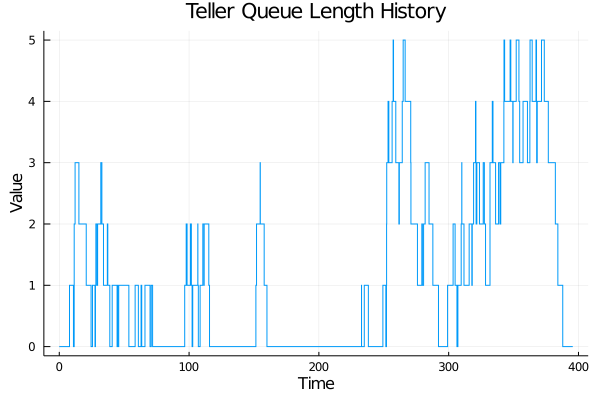

In [13]:
run_simulation(100)